In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import random

plt.rcParams['font.sans-serif'] = ['SimHei']

## Load Dataset

In [33]:
df1 = pd.read_csv('Datasets\Aggregation.txt', header= None,sep=' ')
data1 = df1.values
data1[:5,:]

array([[15.55, 28.65],
       [14.9 , 27.55],
       [14.45, 28.35],
       [14.15, 28.8 ],
       [13.75, 28.05]])

In [34]:
df2 = pd.read_csv('Datasets\D31.txt', header= None,sep=' ')
data2 = df2.values
data2[:5,:]

array([[25.0514,  5.7475],
       [26.6614,  7.3414],
       [25.2653,  6.2466],
       [25.2285,  4.7447],
       [25.7529,  5.1564]])

In [35]:
df3 = pd.read_csv('Datasets\R15.txt', header= None,sep=' ')
data3 = df3.values
data3[:5,:]

array([[ 9.802, 10.132],
       [10.35 ,  9.768],
       [10.098,  9.988],
       [ 9.73 ,  9.91 ],
       [ 9.754, 10.43 ]])

## Dataset Distribution

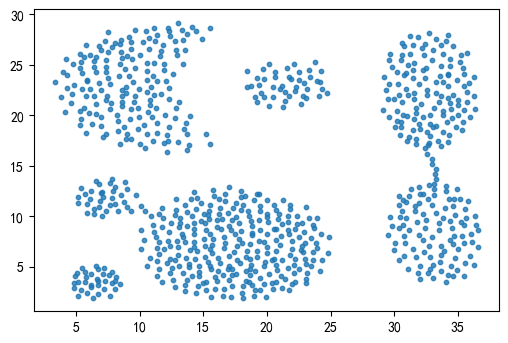

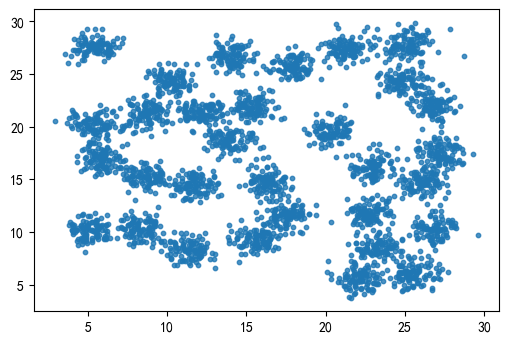

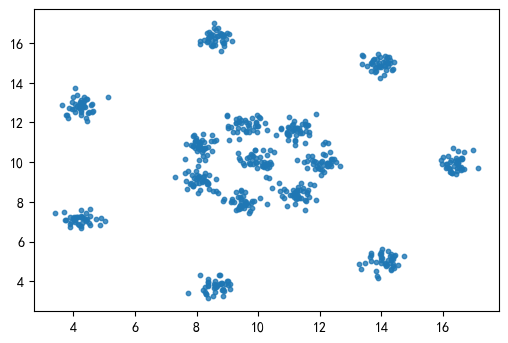

In [36]:
plt.figure(dpi = 100)
plt.scatter(data1[:,0],data1[:,1],s=10,alpha=0.8)
plt.show()
plt.figure(dpi = 100)
plt.scatter(data2[:,0],data2[:,1],s=10,alpha=0.8)
plt.show()
plt.figure(dpi = 100)
plt.scatter(data3[:,0],data3[:,1],s=10,alpha=0.8)
plt.show()

## DPC

In [102]:
class DPC(object):
    '''
    distance : 距离矩阵
    data : 数据集
    centers : 簇中心的索引
    d_c : 截断距离
    threshold : 用于选出聚类中心的gamma的阈值
    k : 簇的数量
    cluster : 数据对应的簇
    rho : 密度
    delta : 距离
    nearest_neighbor : 密度高于当前点的最近点序号
    percent : 选取dc时的比例
    outlier : 是否判断噪声点
    outlier_percent : 噪声点比例
    halos: 光环
    '''
    def __init__(self):
        self.distance = None
        self.centers = None
        self.d_c = None
        self.threshold = None
        self.k = None
        self.cluster = None
        self.rho = None
        self.delta = None
        self.nearest_neighbor =None
        self.percent = None
        self.outlier = None
        self.outlier_percent = None
        self.halos = None

    # 计算距离
    def Distance(self,data):
        m = data.shape[0]
        self.distance = np.zeros([m,m])
        self.distance = np.linalg.norm(data-data[:,None],axis=-1)
        return 

    # 计算截断距离
    def get_d_c(self,percent):
        n = int(percent * (len(self.distance)**2))
        dis_plus = np.sort(np.reshape(self.distance,len(self.distance)**2))
        self.d_c = dis_plus[n]
        return

    # 计算局部密度
    def LocalDensity(self):
        m = self.distance.shape[0]
        self.rho = np.zeros(m)
        for i in range(m):
            self.rho[i] = np.sum(np.where(self.distance[i,:] < self.d_c, 1, 0)) 
        return 

    # 计算高密度最小距离
    def Delta(self):
        m = self.distance.shape[0]
        delta = np.zeros(m)
        nearest_neighbor = np.zeros(m)
        rho_index = np.argsort(-self.rho) # 密度降序的索引
        for i in range(m):
            if i == 0:
                delta[rho_index[i]] = np.max(self.distance[rho_index[i],:])
                continue
            # 比当前点密度大的序号
            greater_index = rho_index[:i]
            # 当前点的高密度最小距离
            delta[rho_index[i]] = np.min(self.distance[rho_index[i],greater_index])
            # 密度高于当前点的最近点序号
            nearest_neighbor[rho_index[i]] = greater_index[np.argmin(self.distance[rho_index[i],greater_index])]
        self.delta = delta
        self.nearest_neighbor = nearest_neighbor
        return 

    # 获取簇中心
    def Centers(self):
        product = self.rho * self.delta
        product_index = np.argsort(-product)
        for i,j in enumerate(product_index):
            if product[j] < self.threshold:
                self.k = i
                break
        self.centers = product_index[:self.k]
        return

    # 为非簇中心样本点归簇
    def Clustering(self):
        for i,center in enumerate(self.centers):
            self.cluster[center] = i + 1
        rho_index = np.argsort(-self.rho)
        for i in range(len(self.rho)):
            if self.cluster[rho_index[i]] == 0:
                self.cluster[rho_index[i]] = self.cluster[int(self.nearest_neighbor[rho_index[i]])]
        return

    # 归一化(暂未用到)
    def Norm(self, data):
        Min = np.min(data)
        Max = np.max(data)
        norm_data = (data - Min) / (Max - Min)
        return norm_data

    # 离群点
    def Outliers(self):
        rho_index = np.argsort(self.rho)
        for i in rho_index[:int(self.outlier_percent * len(self.rho))]:
            self.cluster[i] = 0

    # 光晕点
    def Halo(self):
        bord_rho = np.zeros(self.k)
        self.halos = np.zeros(len(self.rho))
        for i in range(len(self.distance)):
            for j in range(len(self.distance)):
                if (self.distance[i][j] < self.d_c) and (self.cluster[i] != self.cluster[j]):
                    rho_aver = (self.rho[i] + self.rho[j]) / 2
                    if (rho_aver>bord_rho[int(self.cluster[i])-1]):
                        bord_rho[int(self.cluster[i])-1]=rho_aver
                    if (rho_aver>bord_rho[int(self.cluster[j])-1]):
                        bord_rho[int(self.cluster[j])-1]=rho_aver

        for i in range(len(self.rho)):
            if self.rho[i] < bord_rho[int(self.cluster[i])-1]:
                self.halos[i] = 1
        
    # 画出聚类结果
    def ShowCluster(self,data):
        colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F'] # 颜色列表
        plt.figure(dpi = 200)
        for i in range(self.k):
            color = ""
            for j in range(6):
                color += colorArr[random.randint(0,14)] # 随机RGB
            color = '#' + color
            # 画簇内部点
            x,y=data[self.cluster == i + 1][:,0],data[self.cluster == i + 1][:,1]
            plt.scatter(x,y,c=color,label='cluster '+str(i+1), s = 5, alpha=0.8)
        # 画光环
        x,y=data[self.halos == 1][:,0],data[self.halos == 1][:,1]
        plt.scatter(x,y,c='black',label = 'halos', s=2)
        # 画噪声点
        x,y=data[self.cluster == 0][:,0],data[self.cluster == 0][:,1]
        plt.scatter(x,y,c='black',label = 'noise', s=1)
        # 画簇中心
        plt.scatter(data[self.centers,0],data[self.centers,1], c = 'black', marker= '+',label='centers')
        col = int(len(self.centers) / 18) + 1
        # 显示图例
        plt.legend(loc='upper right',bbox_to_anchor=(1 + col*0.29,1.0),borderaxespad=0.,ncol = col)
        plt.show()

    # 画出rho-delta图
    def ShowRhoDelta(self):
        plt.figure(dpi = 150)
        plt.xlabel("ρ")
        plt.ylabel("δ")
        plt.title('Decision Graph')
        plt.scatter(self.rho, self.delta, c='none', edgecolors='black', marker='o', alpha=0.5)
        plt.show()
        return

    # 画出gamma图
    def ShowGamma(self,threshold=None):
        product = self.rho * self.delta
        if threshold == None:
           threshold = np.average(product) * 8
        plt.figure(dpi = 150)
        plt.xlabel("n")
        plt.ylabel("γ")
        plt.title("γ-n picture")
        plt.plot(np.arange(0,len(self.rho)/2,5),np.ones([len(np.arange(0,len(self.rho)/2,5)),1]) * threshold ,color='g',ls='--',label="threshold:γ="+str(threshold))
        plt.scatter(list(range(len(self.rho))), np.abs(np.sort(-product)), c='black', marker='o', s=1, alpha=0.5)
        plt.legend()
        plt.show()
        return

    def fit(self,data, threshold, percent = 0.01, halo=False ,outlier = False, outlier_percent = 0.01):
        self.percent = percent
        self.threshold = threshold
        self.cluster = np.zeros(data.shape[0])
        self.Distance(data)
        self.get_d_c(percent)
        self.LocalDensity()
        self.Delta()
        self.Centers()
        self.Clustering()
        if halo:
            self.Halo()
        if outlier:
            self.outlier_percent = outlier_percent
            self.Outliers()


## Aggregation Dataset

首先计算局部密度和相对距离，算出$\delta和\rho$画出决策图发现并不是很容易选出聚类中心，所以转而画出$\gamma$图(这里`ShowGamma()`函数若无输入，则有个默认threshold，观察图片对threshold进行修改)

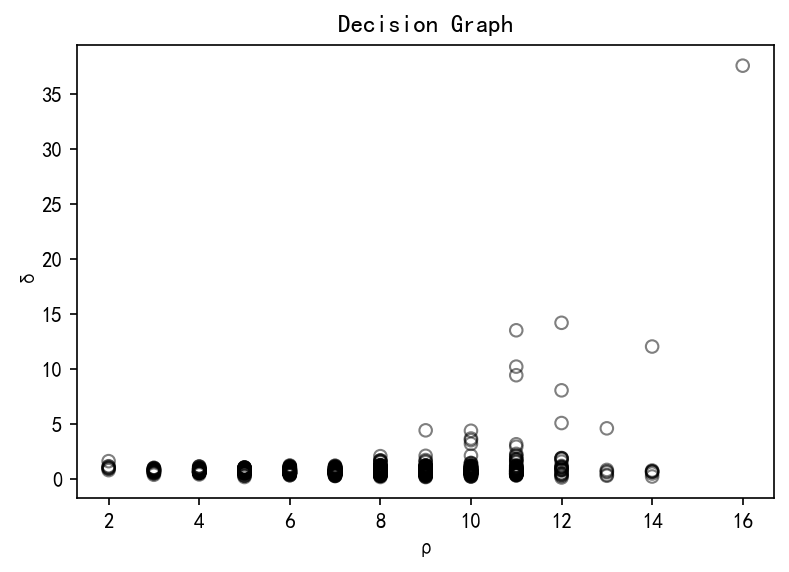

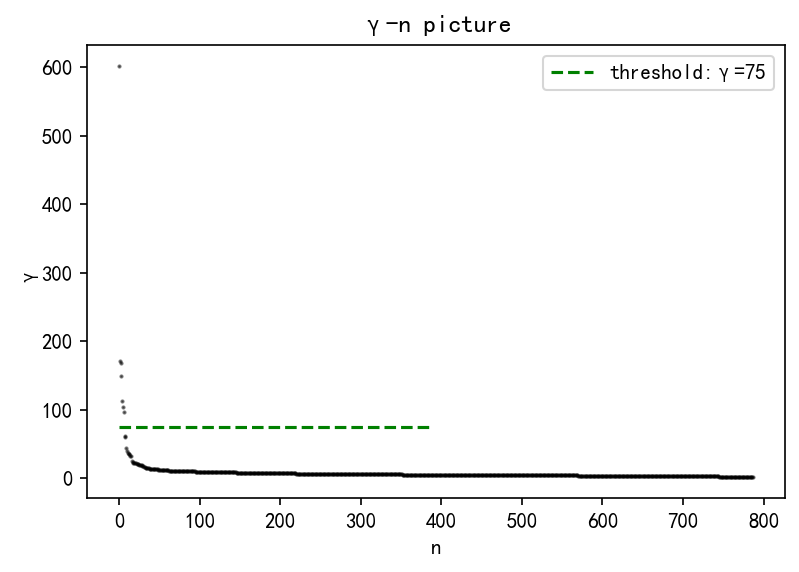

In [38]:
model1 = DPC()
model1.Distance(data1)
model1.get_d_c(0.01)
model1.LocalDensity()
model1.Delta()
model1.ShowRhoDelta()
model1.ShowGamma(75)

确定了threshold值之后将其传回模型中，进行聚类

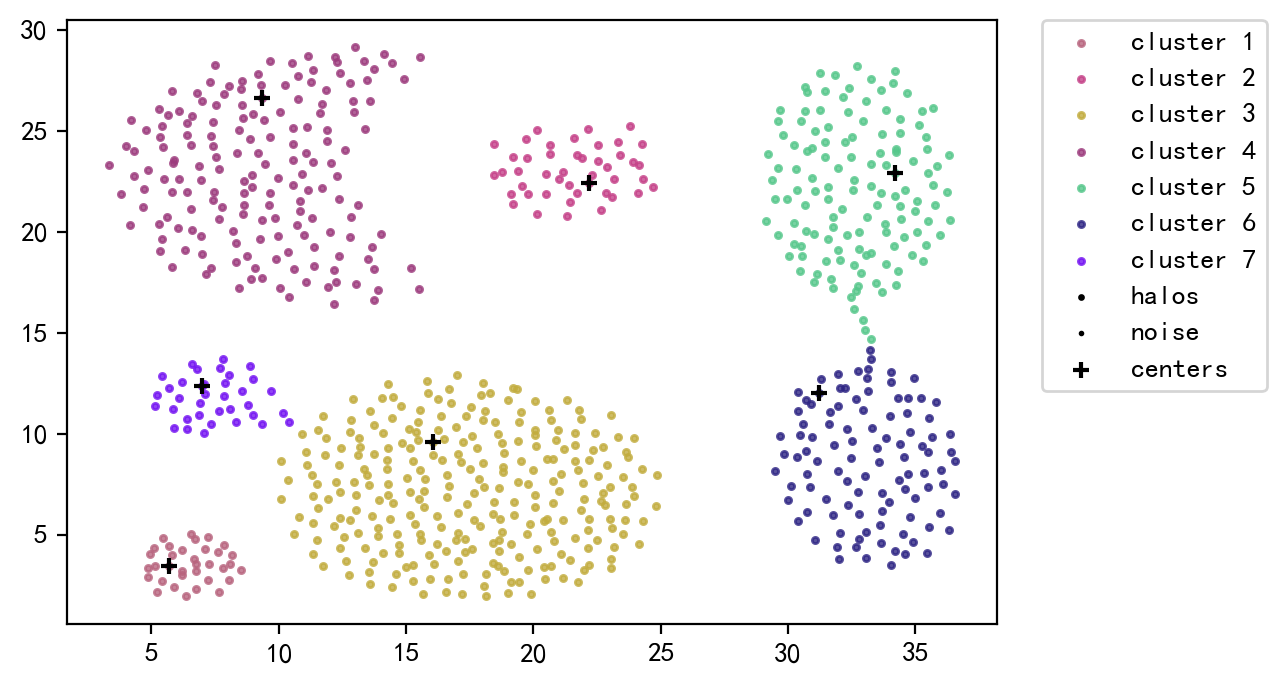

In [39]:
model1.fit(data1,75,percent=0.01)
model1.ShowCluster(data1)

可以看出DPC算法将上述数据集划分为7个簇，与人眼效果基本一致，效果较好

## D31 Dataset

和上面的步骤相同，画出决策图，调整threshold，聚类

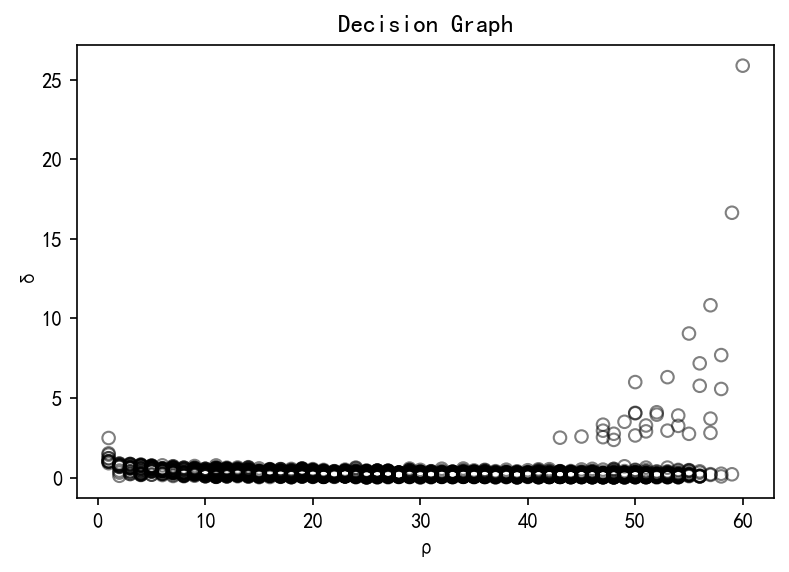

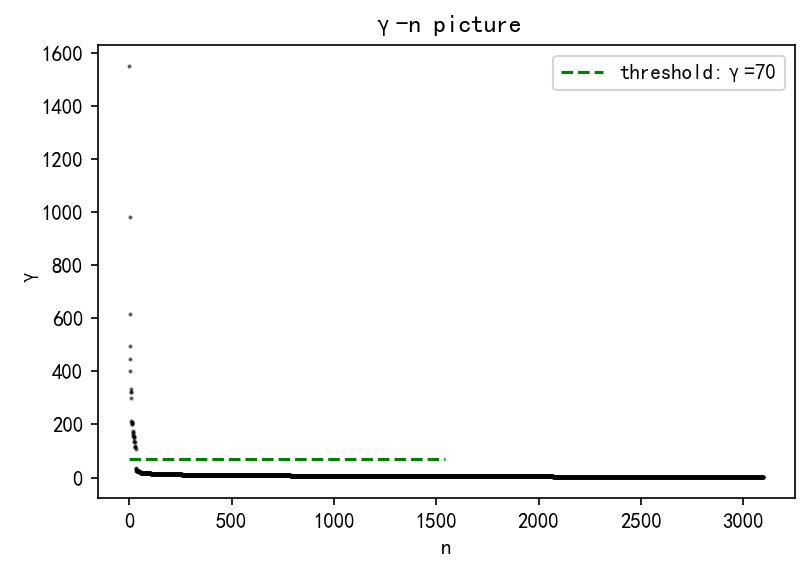

In [40]:
model2 = DPC()
model2.Distance(data2)
model2.get_d_c(0.01)
model2.LocalDensity()
model2.Delta()
model2.ShowRhoDelta()
model2.ShowGamma(70)

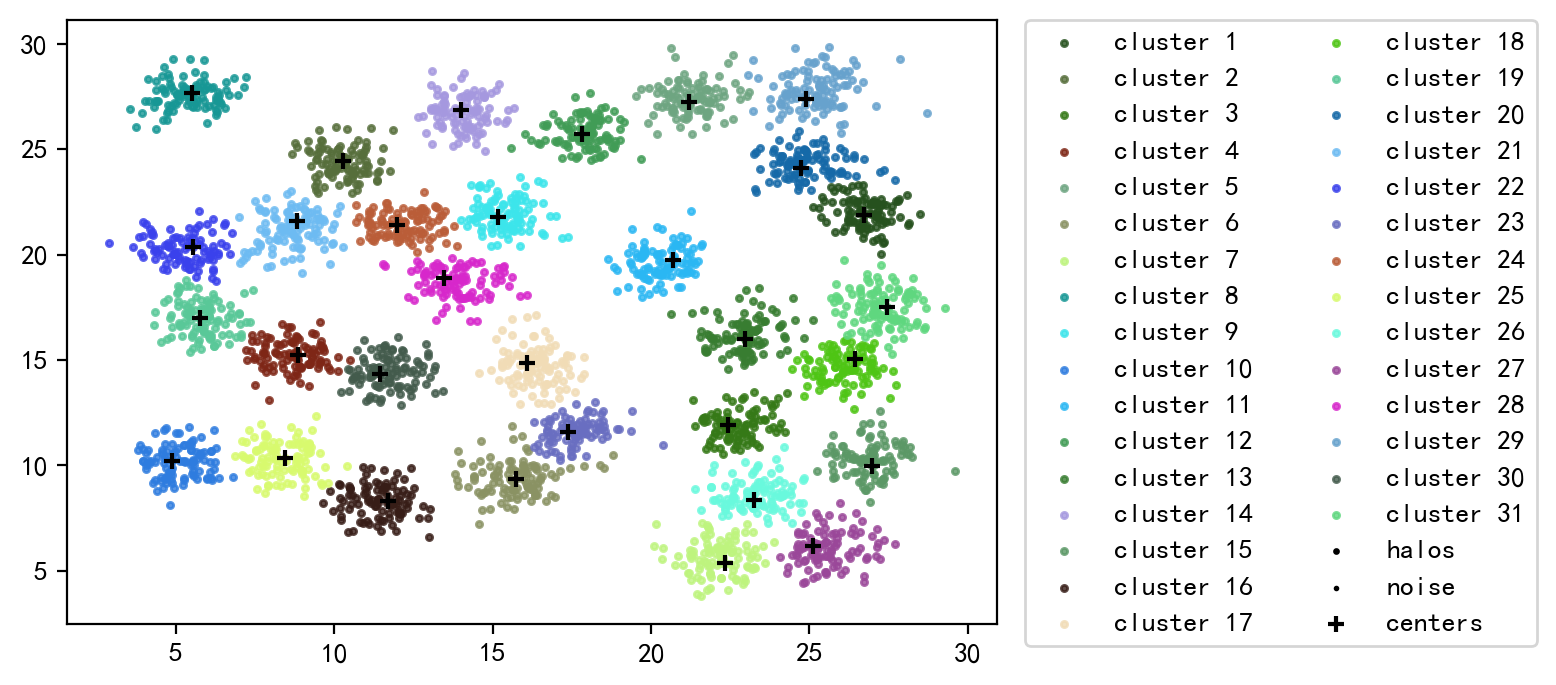

In [41]:
model2.fit(data2,70,percent=0.01)
model2.ShowCluster(data2)

可以看出DPC算法将上述数据集划分为31个簇，与人眼效果基本一致，效果较好

## R15 Dataset

依旧按上述步骤进行聚类

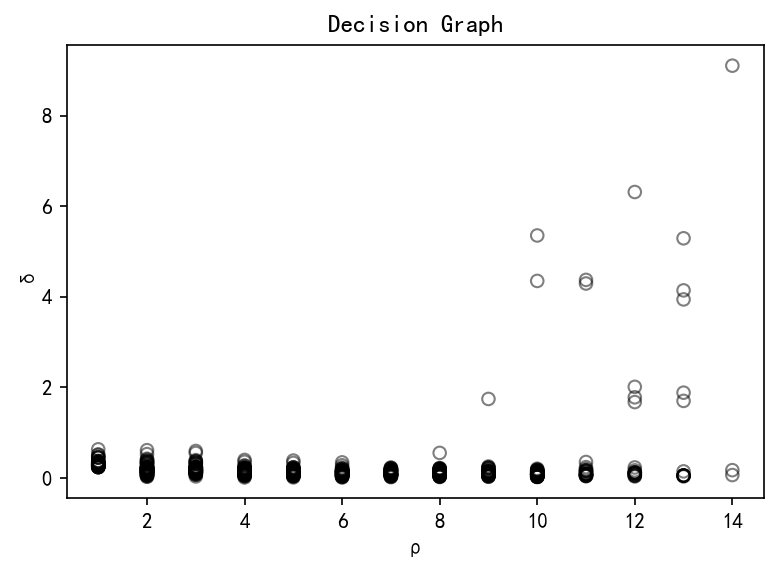

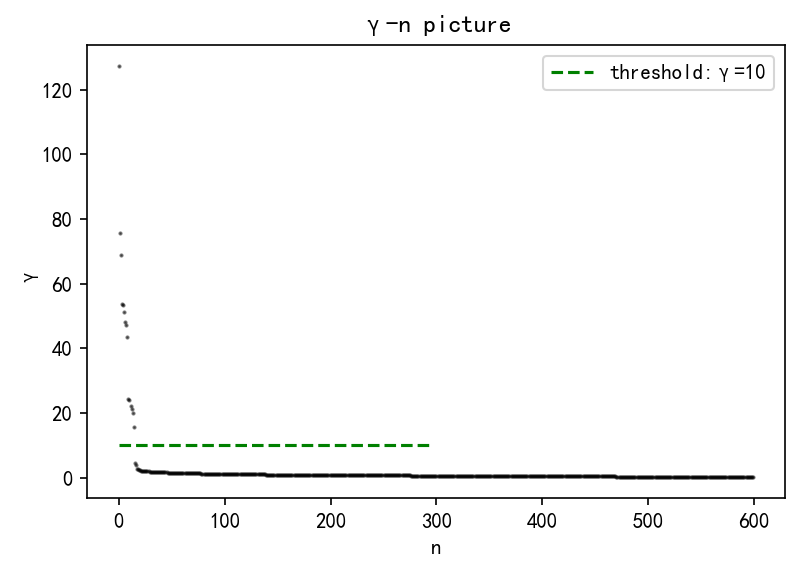

In [42]:
model3 = DPC()
model3.Distance(data3)
model3.get_d_c(0.01)
model3.LocalDensity()
model3.Delta()
model3.ShowRhoDelta()
model3.ShowGamma(10)

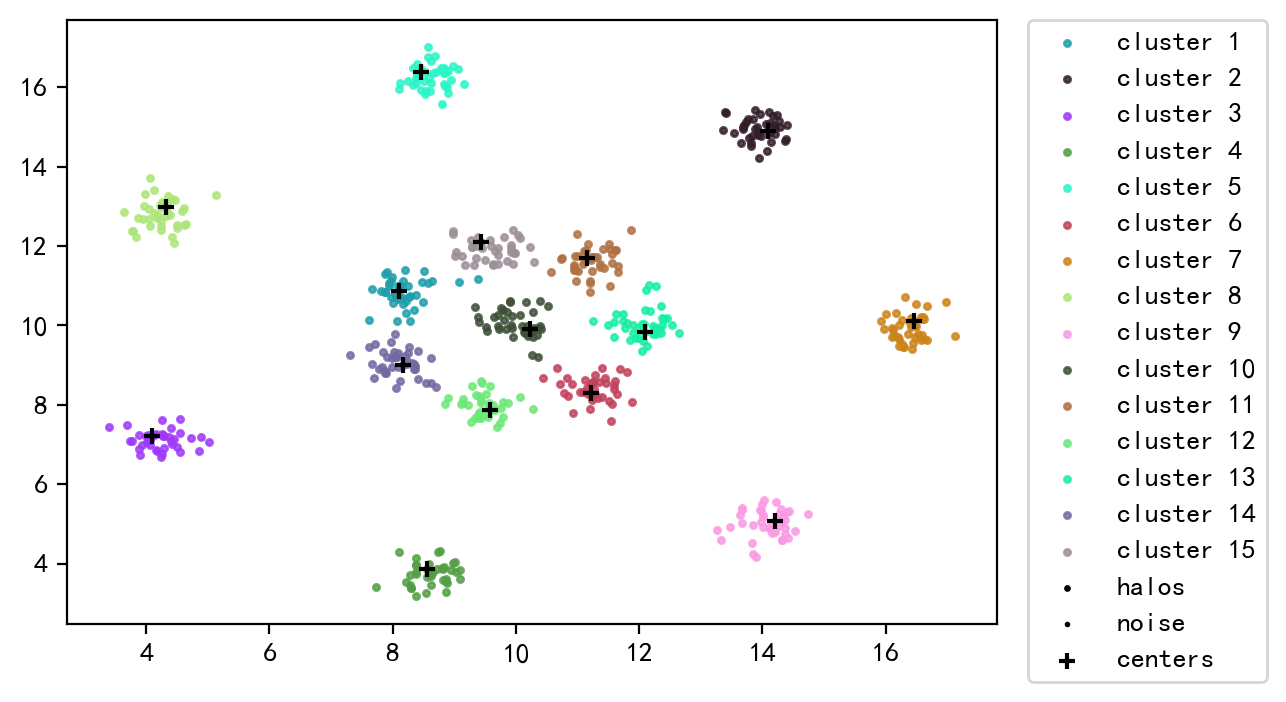

In [43]:
model3.fit(data3,10,percent=0.01)
model3.ShowCluster(data3)

可以看出DPC算法将上述数据集划分为15个簇，与人眼效果基本一致，效果较好

## DBI

调库计算聚簇结果的DBI

In [44]:
from sklearn import metrics

print("Aggregation  DBI:",metrics.davies_bouldin_score(data1,model1.cluster))
print("D31  DBI:",metrics.davies_bouldin_score(data2,model2.cluster))
print("R15  DBI:",metrics.davies_bouldin_score(data3,model3.cluster))

Aggregation  DBI: 0.5066329067070742
D31  DBI: 0.5510264905853722
R15  DBI: 0.3142726133753593


## 选出Halos

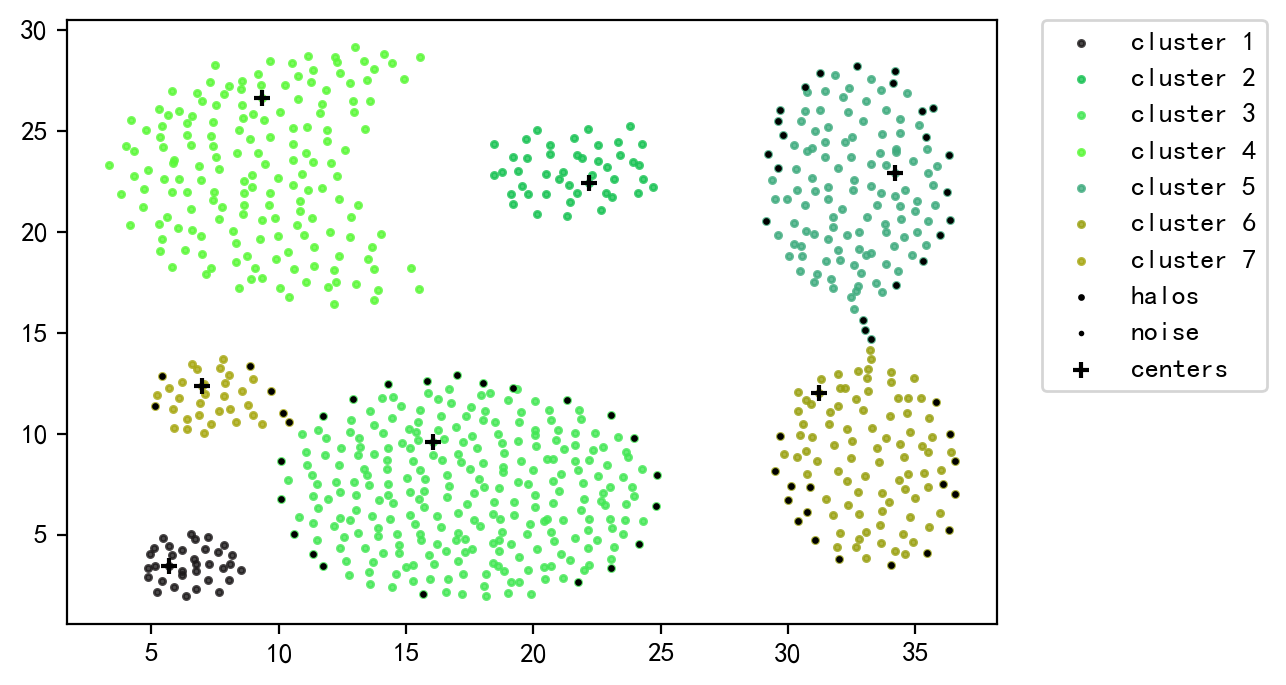

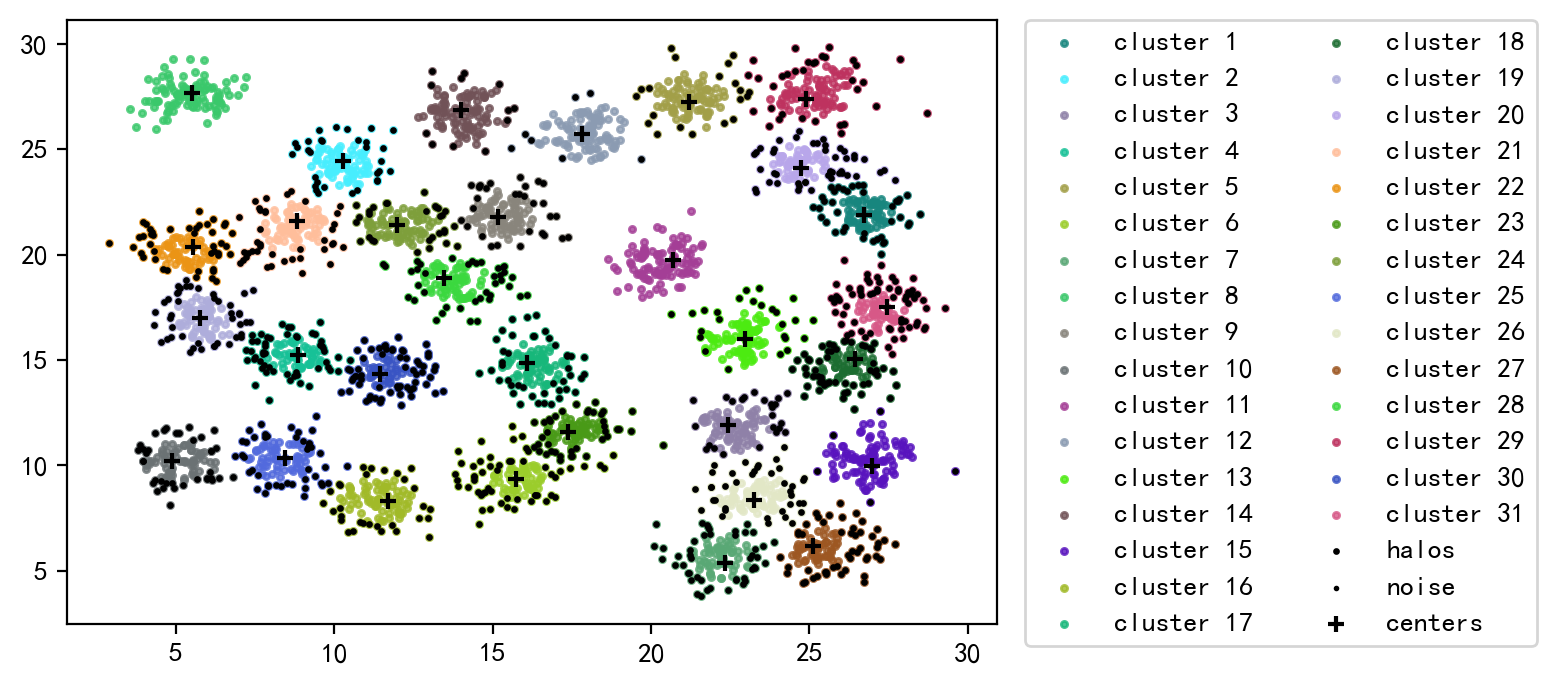

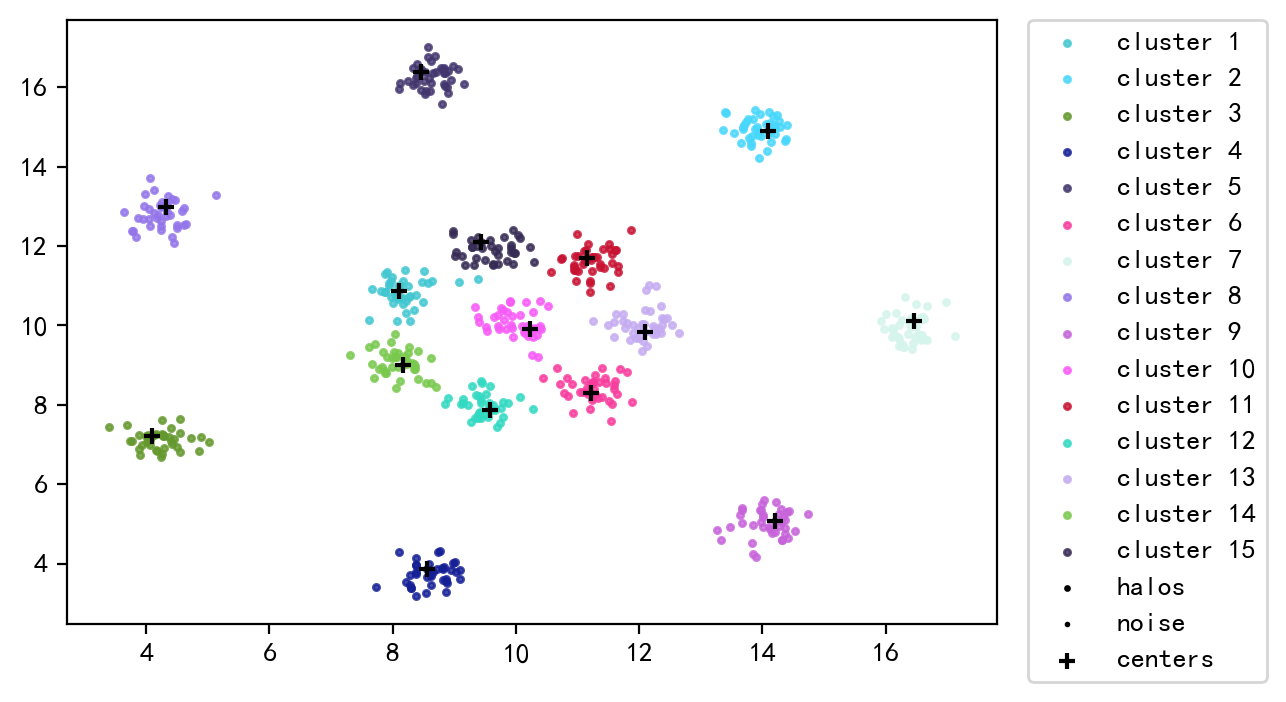

In [48]:
model1.fit(data1,75,percent=0.01,halo=True)
model1.ShowCluster(data1)
model1.fit(data2,70,percent=0.01,halo=True)
model1.ShowCluster(data2)
model1.fit(data3,10,percent=0.01,halo=True)
model1.ShowCluster(data3)

## 与`KMeans`、`DBscan`算法的对比

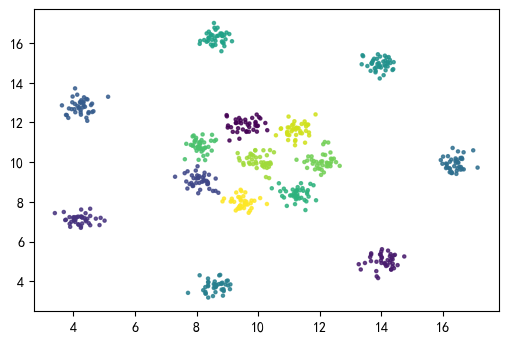

In [54]:
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=15).fit_predict(data3)
plt.figure(dpi = 100)
plt.scatter(data3[:,0],data3[:,1], c=y_pred,s=5,alpha=0.8)
plt.show()

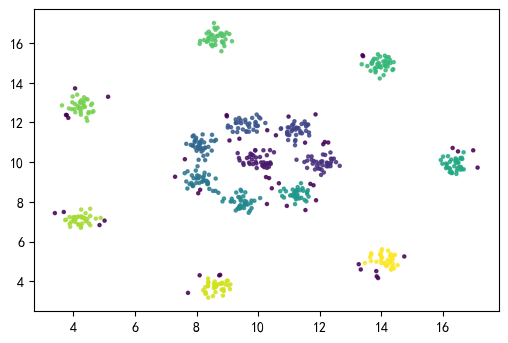

In [101]:
from sklearn.cluster import DBSCAN

y_pred = DBSCAN(eps=0.3,min_samples=2*2).fit_predict(data3)
plt.figure(dpi = 100)
plt.scatter(data3[:,0],data3[:,1],c=y_pred,s=5,alpha=0.8)
plt.show()